In [21]:
!pip install shap

import numpy as np
import pandas as pd
import pickle
import pydotplus
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from IPython.display import Image

This function converts the dataset in one-hot encoded one. The binary attributes are kept untouched.

In [22]:
def reshaping(df, remove_cols=None):
    temp = df.copy()
    if remove_cols != None:
        temp.drop(remove_cols, axis=1, inplace = True)
        
    ohe_cols = [col for col in temp.columns if len(temp[col].unique()) > 2]

    return pd.get_dummies(temp, columns=ohe_cols)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For transforming with one-hot encoding the test dataset it was decided to append it to the original one, apply the transformation, and extract it again. In this way it was possible to obtain the same one-hot encoding transformation as the previous notebooks.

In [24]:
def prepared_df(dfold):
    column_names = [
        'class',
        'cap-shape',
        'cap-surface',
        'cap-color',
        'bruises',
        'odor',
        'gill-attachment',
        'gill-spacing',
        'gill-size',
        'gill-color',
        'stalk-shape',
        'stalk-root',
        'stalk-surface-above-ring',
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat'
    ]
    
    file_name = input("File name: ")
    with open(file_name, 'r') as f:
        first_token = f.readline().split(',')[0]
        if first_token == 'class':  # The file contains the column names.
            df = pd.read_csv(file_name, sep=",")
        else:
            df = pd.read_csv(file_name, sep=",", names=column_names)
    
    # Label encoding for binary or numerical features.
    df.drop('veil-type', axis=1, inplace=True)
    df['class'] = df['class'].map({'p': 0, 'e': 1}).astype(str)
    df['bruises'] = df['bruises'].map({'t': 1, 'f': 0}).astype(str)
    df['gill-attachment'] = df['gill-attachment'].map( {'a': 1, 'f': 0}).astype(str)
    df['gill-spacing'] = df['gill-spacing'].map({'c': 0, 'w': 1}).astype(str)
    df['gill-size'] = df['gill-size'].map({'b': 1, 'n': 0}).astype(str)
    df['stalk-shape'] = df['stalk-shape'].map({'e': 1, 't': 0}).astype(str)
    df['ring-number'] = df['ring-number'].map({'n': 0, 'o': 1, 't': 2}).astype(str)
    df.rename(columns={"class": "edible"}, inplace=True)
    dfold = dfold.astype(str)
    
    temp = dfold.append(df)

    temp = reshaping(temp, remove_cols=['stalk-root'])
    return temp.tail(len(df))

In [25]:
df_complete = pd.read_csv('/content/drive/MyDrive/BDA/mushrooms_clean.csv', sep=",", index_col=0)
df = prepared_df(df_complete)

File name: mushrooms.txt


In [26]:
knn_features = [
    'edible',
    'bruises',
    'odor_f',
    'odor_n', 
    'odor_p',
    'stalk-color-below-ring_y',
    'spore-print-color_r'
]

df = df[knn_features]

# KNN

## Predictions

In [27]:
with open('/content/drive/MyDrive/BDA/final/knn.pickle', 'rb') as f:
    knn = pickle.load(f)

In [28]:
label = df.pop('edible')
test_pred = knn.predict(df)

In [29]:
for i, (pred, truth) in enumerate(zip(test_pred, label)):
    print(f'Record {i} correctly predicted: {pred == int(truth)}')

Record 0 correctly predicted: True
Record 1 correctly predicted: True
Record 2 correctly predicted: True
Record 3 correctly predicted: True
Record 4 correctly predicted: True
Record 5 correctly predicted: True
Record 6 correctly predicted: True
Record 7 correctly predicted: True
Record 8 correctly predicted: True
Record 9 correctly predicted: True
Record 10 correctly predicted: True
Record 11 correctly predicted: True
Record 12 correctly predicted: True
Record 13 correctly predicted: True
Record 14 correctly predicted: True
Record 15 correctly predicted: True
Record 16 correctly predicted: True
Record 17 correctly predicted: True
Record 18 correctly predicted: True
Record 19 correctly predicted: True
Record 20 correctly predicted: True
Record 21 correctly predicted: True


## Explanations

In [30]:
kernel_explainer = shap.KernelExplainer(knn.predict, df)
knn_shap_values = kernel_explainer.shap_values(df)

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


  0%|          | 0/22 [00:00<?, ?it/s]

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

In [31]:
shap.initjs()
for i in range(len(df)):
    print(f'Record n. {i}')
    display(shap.force_plot(kernel_explainer.expected_value, knn_shap_values[i], df.iloc[i]))

Record n. 0


Record n. 1


Record n. 2


Record n. 3


Record n. 4


Record n. 5


Record n. 6


Record n. 7


Record n. 8


Record n. 9


Record n. 10


Record n. 11


Record n. 12


Record n. 13


Record n. 14


Record n. 15


Record n. 16


Record n. 17


Record n. 18


Record n. 19


Record n. 20


Record n. 21


# Decision Tree

## Predictions

In [32]:
df = prepared_df(df_complete)

dt_features = [
    'edible',
    'bruises', # yes/no blue stains
    'odor_n',  # no odor
    'odor_p',  # pungent
    'spore-print-color_h', # chocolate
    'spore-print-color_r', # green
    'habitat_u' # urban
]

df = df[dt_features]

File name: mushrooms.txt


In [33]:
with open('/content/drive/MyDrive/BDA/final/dt.pickle', 'rb') as f:
    dt = pickle.load(f)

In [34]:
label = df.pop('edible')
test_pred = dt.predict(df)

In [35]:
for i, (pred, truth) in enumerate(zip(test_pred, label)):
    print(f'Record {i} correctly predicted: {pred == int(truth)}')

Record 0 correctly predicted: True
Record 1 correctly predicted: True
Record 2 correctly predicted: True
Record 3 correctly predicted: True
Record 4 correctly predicted: True
Record 5 correctly predicted: True
Record 6 correctly predicted: True
Record 7 correctly predicted: True
Record 8 correctly predicted: True
Record 9 correctly predicted: True
Record 10 correctly predicted: True
Record 11 correctly predicted: True
Record 12 correctly predicted: True
Record 13 correctly predicted: True
Record 14 correctly predicted: True
Record 15 correctly predicted: True
Record 16 correctly predicted: True
Record 17 correctly predicted: True
Record 18 correctly predicted: True
Record 19 correctly predicted: True
Record 20 correctly predicted: True
Record 21 correctly predicted: True


## Explanations

We recall that the most important features are:
* odor_n (+)
* bruises (+)
* odor_f (-)
* odor_p (-)

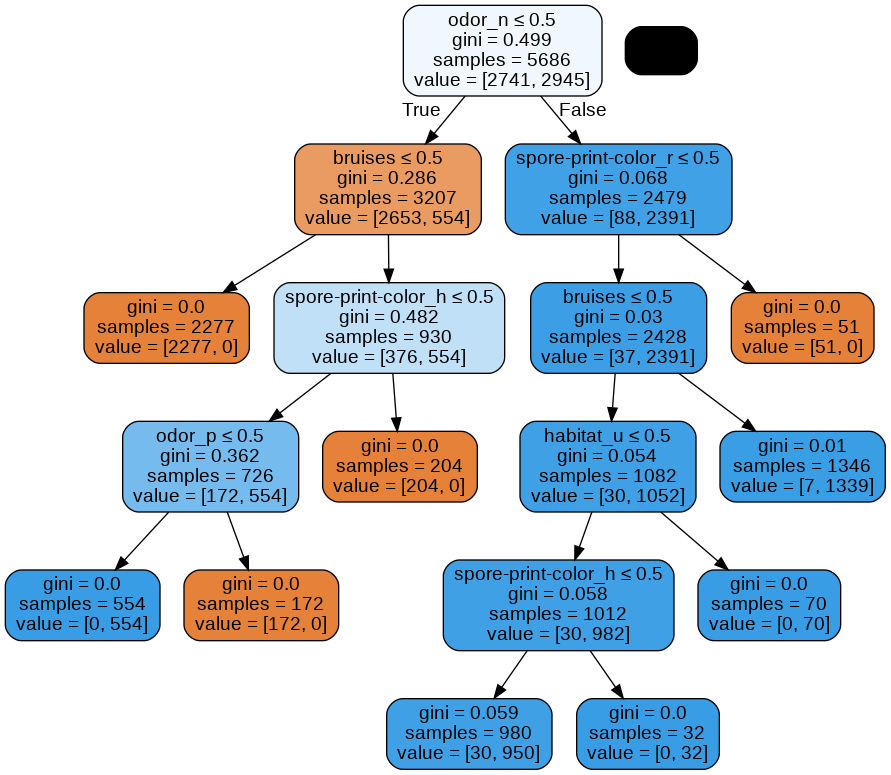

In [36]:
dot_data = tree.export_graphviz(
    dt,
    out_file=None,
    feature_names=dt_features[1:],
    filled=True,
    rounded=True,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())